In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
img_uri = 's3://sandmines/test/Sone_Dehri_XX-xx_YY-yy/rgb/Sone_Dehri_XX-xx_YY-yy_YYYYMMDD_rgb.tif'
labelbox_export_uri = "https://sandmines.s3.us-west-1.amazonaws.com/test/Sone_Dehri_XX-xx_YY-yy/polygons/Sone_Dehri_XX-xx_YY-yy_YYYYMMDD_polygons.ndjson"
geojson_path = "../data/sandmines_dummy_example.geojson"

TILE_SIZE = 450

## Prepare Dateset

First, convert the output of labelbox into a geojson. Store the geojson in the local file system.  

In [ ]:
from urllib.request import urlopen
import json
from pprint import pprint

labelbox_export_data = json.loads(
    urlopen(labelbox_export_uri).read()
)
labelbox_projects = list(labelbox_export_data['projects'].values())

# We expect that there exist only one "project"
assert len(labelbox_projects) == 1    

labels = labelbox_projects[0]['labels']

# We expect that there exist only one "label"
assert len(labels) == 1    

objects = labels[0]['annotations']['objects']
polygons = [o['geojson'] for o in objects]

geojson_out = {
    "type": "FeatureCollection",
    "features": [
        {"geometry": polygon}
        for polygon in polygons
    ]
}

with open(geojson_path, 'w') as file:
    json.dump(geojson_out, file, indent=2)

Setup rastervision SemanticSegmentationSlidingWindowGeoDataset

In [3]:
from rastervision.core.data import (
    ClassInferenceTransformer, GeoJSONVectorSource,
    RasterioSource, RasterizedSource, Scene, SemanticSegmentationLabelSource
)
from rastervision.pytorch_learner import SemanticSegmentationSlidingWindowGeoDataset
import albumentations as A

from config import CLASS_CONFIG_BINARY_SAND as class_config

img_raster_source = RasterioSource(img_uri, allow_streaming=False)

vector_source = GeoJSONVectorSource(
    geojson_path,
    img_raster_source.crs_transformer,
    ignore_crs_field=True,
    vector_transformers=[
        ClassInferenceTransformer(
            default_class_id=class_config.get_class_id('sandmine'))]
)

label_raster_source = RasterizedSource(
    vector_source,
    background_class_id=class_config.null_class_id,
    extent=img_raster_source.extent
)

label_source = SemanticSegmentationLabelSource(
    label_raster_source, class_config=class_config
)

scene = Scene(0, img_raster_source, label_source)

data_augmentation_transform = A.Compose([
    A.Flip(),
    A.CoarseDropout(max_height=64, max_width=64, max_holes=5)
])

ds = SemanticSegmentationSlidingWindowGeoDataset(scene, TILE_SIZE, 50)
ds_with_augment = SemanticSegmentationSlidingWindowGeoDataset(
    scene, TILE_SIZE, 50, transform=data_augmentation_transform
)

2023-07-11 14:41:29:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmp5waxhjzy
2023-07-11 14:41:32:rastervision.pipeline.file_system.utils: INFO - Downloading s3://sandmines/test/Sone_Dehri_XX-xx_YY-yy/rgb/Sone_Dehri_XX-xx_YY-yy_YYYYMMDD_rgb.tif to /tmp/tmp5waxhjzy/cache/s3/sandmines/test/Sone_Dehri_XX-xx_YY-yy/rgb/Sone_Dehri_XX-xx_YY-yy_YYYYMMDD_rgb.tif...


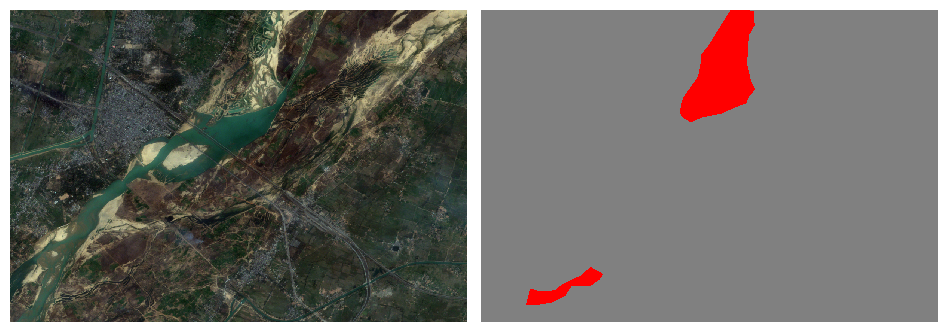

In [4]:
from utils.visualizing import show_rgb_with_labels

show_rgb_with_labels(
    ds.scene.raster_source[:, :],
    ds.scene.label_source[:,:],
    class_config.colors
)

In [ ]:
from utils.visualizing import show_windows, show_labels, show_image

show_windows(
    ds.scene.raster_source[:, :],
    ds.windows,
    title='Sliding windows'
)

In [ ]:
from rastervision.pytorch_learner import SemanticSegmentationVisualizer

viz = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)

x, y = viz.get_batch(ds_with_augment, 5)
viz.plot_batch(x, y, show=True)

## Train

Note that we train and validate on the same data. The only difference is that the training data gets augmented. This is only for dummy demonstrating purposes.

In [12]:
from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig, SolverConfig, SemanticSegmentationLearnerConfig, SemanticSegmentationLearner
from models.unet.unet_small import UNetSmall

_, _, n_channels = ds.scene.raster_source.shape
n_classes = 2

model = UNetSmall(n_channels, n_classes)

data_cfg = SemanticSegmentationGeoDataConfig(
    class_names=class_config.names,
    class_colors=class_config.colors,
    num_workers=0, # increase to use multi-processing
)

solver_cfg = SolverConfig(
    batch_sz=10,
    lr=3e-2,
    class_loss_weights=[1., 2.]
)

learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg, solver=solver_cfg)

learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    output_dir='../out/unet_small_01',
    model=model,
    train_ds=ds_with_augment,
    valid_ds=ds, 
)
learner.log_data_stats()

2023-07-11 14:45:14:rastervision.pytorch_learner.learner: INFO - Loading checkpoint from ../out/unet_small_01/last-model.pth
2023-07-11 14:45:14:rastervision.pytorch_learner.learner: INFO - train_ds: 260 items
2023-07-11 14:45:14:rastervision.pytorch_learner.learner: INFO - valid_ds: 260 items


learner setup_training()
loss_def_path None
setup_loss()
loss_def_path None
build_loss()
{'weight': tensor([1., 2.])}
Loss:
CrossEntropyLoss()


Show summary of Model

In [7]:
from torchsummary import summary

input_size = (n_channels, TILE_SIZE, TILE_SIZE)
_ = summary(model, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
├─DoubleConv: 1-1                        [-1, 64, 450, 450]        --
|    └─Sequential: 2-1                   [-1, 64, 450, 450]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 450, 450]        1,728
|    |    └─BatchNorm2d: 3-2             [-1, 64, 450, 450]        128
|    |    └─ReLU: 3-3                    [-1, 64, 450, 450]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 450, 450]        36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 450, 450]        128
|    |    └─ReLU: 3-6                    [-1, 64, 450, 450]        --
├─Down: 1-2                              [-1, 128, 225, 225]       --
|    └─Sequential: 2-2                   [-1, 128, 225, 225]       --
|    |    └─MaxPool2d: 3-7               [-1, 64, 225, 225]        --
|    |    └─DoubleConv: 3-8              [-1, 128, 225, 225]       221,696
├─Down: 1-3                              [-1, 256, 112, 112]       --
|

In [13]:
learner.train(epochs=4)

2023-07-11 14:45:23:rastervision.pytorch_learner.learner: INFO - Resuming training from epoch 4
2023-07-11 14:45:23:rastervision.pytorch_learner.learner: INFO - epoch: 4


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

2023-07-11 14:45:50:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.9595925211906433,
 'avg_precision': 0.9466082453727722,
 'avg_recall': 0.9729379415512085,
 'epoch': 4,
 'other_f1': 0.9862833619117737,
 'other_precision': 0.9729379415512085,
 'other_recall': 1.0,
 'sandmine_f1': 0.0,
 'sandmine_precision': 0.0,
 'sandmine_recall': 0.0,
 'train_loss': 0.01941650463984563,
 'train_time': '0:00:13.055035',
 'val_loss': 0.015052285976707935,
 'valid_time': '0:00:13.560026'}


## Evaluate

In [14]:
from rastervision.core.data import SemanticSegmentationLabels

predictions = learner.predict_dataset(
    ds,
    raw_out=True,
    numpy_out=True,
    progress_bar=True
)

pred_labels = SemanticSegmentationLabels.from_predictions(
    ds.windows,
    predictions,
    smooth=True,
    extent=ds.scene.extent,
    num_classes=len(class_config)
)

scores = pred_labels.get_score_arr(pred_labels.extent)
predicted_mine_probability = scores[class_config.get_class_id('sandmine')]

Predicting:   0%|          | 0/260 [00:00<?, ?it/s]

#### Visualize predictions

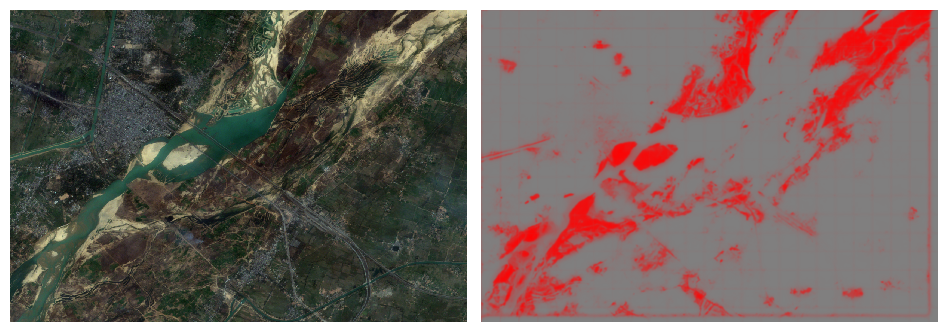

In [16]:
from utils.visualizing import show_rgb_with_labels

show_rgb_with_labels(
    ds.scene.raster_source[:, :],
    predicted_mine_probability,
    #class_config.colors
)

In [ ]:
pred_labels.save(
    '../out/predictions_unet_01/',
    ds.scene.raster_source.crs_transformer,
    class_config=class_config
)